In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
sys.path.insert(0,'../rl_network/'); import ac
sys.path.insert(0,'../memory/'); import episodic as ec
sys.path.insert(0,'../environments/'); import gw; import gridworld_plotting as gp

import experiment as expt
import torch
import uuid
import pickle 

In [2]:
# random events 
sig = 0.8
rewards = np.array([np.random.choice([0,1], p=[sig, 1-sig]) for x in range(100)], dtype=float)
rewards[np.where(rewards==0)] = -0.01

print(rewards)

[ 1.   -0.01 -0.01 -0.01 -0.01 -0.01  1.   -0.01 -0.01 -0.01 -0.01  1.
 -0.01 -0.01 -0.01 -0.01  1.    1.    1.   -0.01 -0.01 -0.01 -0.01 -0.01
 -0.01 -0.01  1.   -0.01 -0.01 -0.01 -0.01  1.    1.   -0.01 -0.01 -0.01
 -0.01 -0.01  1.   -0.01  1.   -0.01  1.   -0.01 -0.01 -0.01 -0.01 -0.01
 -0.01 -0.01 -0.01 -0.01 -0.01  1.   -0.01 -0.01 -0.01 -0.01  1.    1.
 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01  1.   -0.01  1.   -0.01
 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01  1.    1.   -0.01 -0.01 -0.01
 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01  1.    1.   -0.01  1.
 -0.01  1.    1.   -0.01]


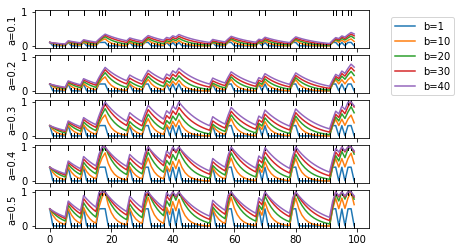

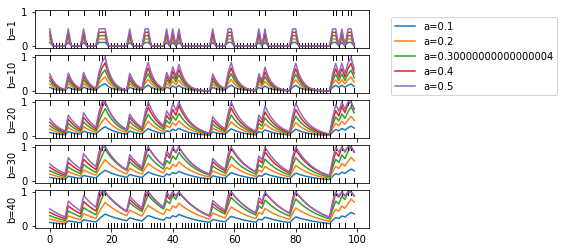

In [3]:
#ewards = np.zeros(100)
#every_other = np.arange(10,40,3)
#every_one = np.arange(40,50)
#rewards[every_other] =1 


def poops(x, alpha, beta):    
    toots = alpha*np.exp(-np.arange(len(x))/beta) # exponential decay with time 
    poops = np.convolve(toots,x, mode='full')[0:len(x)]
    return poops

def turds(x, alpha, beta):
    #alpha = bump size
    # beta = number of steps to decay to 0.01
    threshold = 0.01
    decay = np.power(threshold,1/beta)
    a = np.empty_like(x, dtype=float)
    
    for ind, i in enumerate(x):
        if ind == 0:
            a[ind] = i*alpha
        else:
            calc = decay*a[ind-1] + i*alpha
            if calc > 1:
                calc = 1
            a[ind] = calc
    return a

alphas = np.arange(1,6)*0.1
betas = np.arange(0,50,10)
betas[0] = 1
## iterate over alphas: 
fig, ax = plt.subplots(len(alphas), 1, sharex=True, sharey=True)
for xx, i in enumerate(alphas):
    for j in betas:
        pp = turds(rewards,alpha=i,beta=j)
        ax[xx].plot(rewards,'k|')
        ax[xx].plot(pp,label=f'b={j}')
        ax[xx].set_ylabel(f'a={np.round(i,2)}')
        
ax[0].legend(bbox_to_anchor=(1.05,0.95))
plt.show()
plt.close()

# iterate over betas:
fig, ax = plt.subplots(len(betas),1, sharex=True, sharey=True)
for yy, j in enumerate(betas):
    for i in alphas:
        pp = turds(rewards,alpha=i, beta=j)
        ax[yy].plot(rewards,'k|')
        ax[yy].plot(pp,label=f'a={i}')
        ax[yy].set_ylabel(f'b={np.round(j,2)}')
ax[0].legend(bbox_to_anchor=(1.05,0.95))
plt.show()
plt.close()

# Create Environment




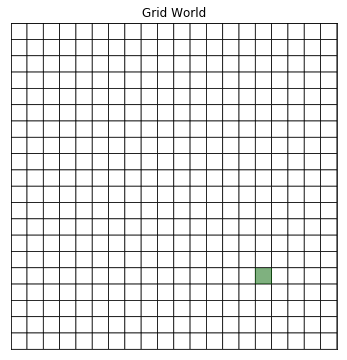

In [4]:
reload(expt)
reload(gw)
reload(ac)
rows, columns = 20,20
env_type = None
penalty = -0.01 

NUM_TRIALS = 5000
NUM_EVENTS = 250


reward_location = (15,15)
env = gw.GridWorld(rows=rows,cols=columns,env_type=env_type,
                       rewards = {reward_location:1},
                       step_penalization=penalty,
                       rho=0.0,
                   actionlist = ['Down', 'Up', 'Right', 'Left'],
                       rewarded_action=None, barheight=10)
    
fig = gw.plotWorld(env, scale=0.3, four_actions=True)

In [6]:
training = {
    'load_model':  True,
    'load_dir':    '',
    'freeze_w':    False,

    'input_dims':  env.observation.shape,
    'action_dims': len(env.action_list),
    'hidden_types':['conv','pool','conv', 'pool', 'linear','linear'],
    'hidden_dims': [None, None, None, None, 100, 200],
    'use_SR':      True,

    'rfsize':      5,

    'gamma':       0.98,
    'eta':         5e-4,

    'use_EC':      True,
    'EC':          {},
    'cachelim':    300
    }

testing_1 = training.copy()
testing_1.update({'load_model':True, 'freeze_w':True})

testing_2 = testing_1.copy()
testing_2.update({'use_EC':True})

testing_4 = testing_1.copy()
testing_4.update({'freeze_w':False})

testing_5 = testing_4.copy()
testing_5.update({'use_EC':True})

agent_params = [training, testing_1, testing_2, testing_2, testing_4, testing_5, testing_5]

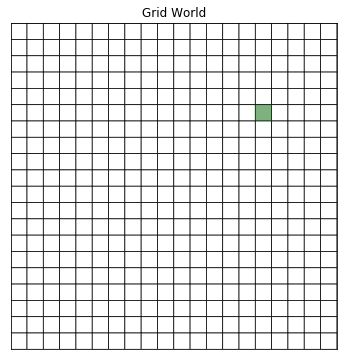

In [7]:
env.rewards = {(5,15):1}
env.buildRewardFunction()
fig = gw.plotWorld(env, scale=0.3, four_actions=True)

In [39]:
#5a7fb825-f567-4a9b-b6d8-f00ae6d7c854
alphas = np.arange(1,6)*0.1
betas = np.arange(2,10)
print(alphas)
print(betas)

[0.1 0.2 0.3 0.4 0.5]
[2 3 4 5 6 7 8 9]


In [8]:
reload(expt)

alphas = np.arange(1,6)*0.1
betas = np.arange(0,50,10)
betas[0] =1 

experiment_type = 0
if experiment_type is not 0: 
    id_key = input('Weights to load: ')
    agent_params[experiment_type]['load_dir'] = f'../data/outputs/gridworld/weights/{id_key}.pt',
    print(agent_params[experiment_type]['load_dir'])

    
for j in range(1):
    for alpha in alphas:
        for beta in [5]:
            print(f'alpha:{alpha},beta:{beta}')
            # generate agent from given parameters
            agent = ac.make_agent(agent_params[experiment_type])
            print(agent)

            # initialize data storage
            data = {'total_reward': [],
                    'loss': [[],[],[]],
                    'trial_length': [],
                    'trials_run_to_date':0,
                    'pol_tracking':[],
                    'val_tracking':[],
                    'ec_tracking': [],
                    't': [],
                    'mfcs':[]
                   }

            # get unique ID tag for this run
            save_id = uuid.uuid4()

            mem_temp = 0.05 
            ex = expt.test_expt(agent, env, use_mem=agent_params[experiment_type]['use_EC'], mem_temp=mem_temp)
            #ex.run(NUM_TRIALS, 50, data, alpha=alpha,beta=beta)


            if agent_params[experiment_type]['use_EC']:
                mem = ex.episodic
            else:
                mem = None
            if agent.use_SR:
                arch = 'B'
            else: 
                arch = 'A'
                
            #expt.log_experiments(save_id, experiment_type, 
            #                     env, agent, data, mem, 
            #                     save_flag = True, 
            #                     load=agent_params[experiment_type]['load_dir'], arch = arch,
            #                    alpha=alpha, beta=beta)


KeyboardInterrupt: Interrupted by user

NameError: name 'save_id' is not defined

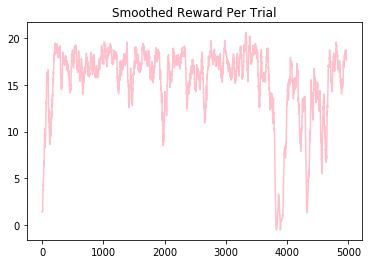

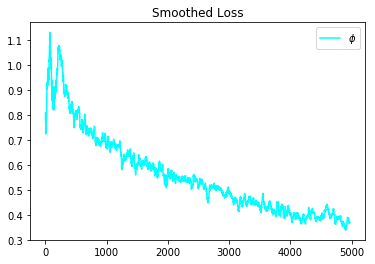

In [35]:
smoothing = 30
plt.figure()
plt.plot(gp.running_mean(data['total_reward'],smoothing),'pink')
plt.title('Smoothed Reward Per Trial')
plt.show()
plt.close()

plt.figure()
#plt.plot(gp.running_mean(data['loss'][0],smoothing), 'darkgreen', label='$\pi$')
#plt.plot(gp.running_mean(data['loss'][1],smoothing), 'lightgreen', label='v')
plt.plot(gp.running_mean(data['loss'][2],smoothing), 'cyan', label='$\phi$')
plt.legend(loc=0)
plt.title('Smoothed Loss')
plt.show()
plt.close()

In [ ]:
reload(expt)

sample_observations = env.get_sample_obs()
pol_grid, val_grid = expt.get_snapshot(sample_observations, env,agent)
gp.plot_pref_pol(env, pol_grid, threshold = 0.1, title='ec_pol_new_rwd',upperbound=2)
gp.plot_polmap(env, pol_grid, threshold = 0.22)
gp.plot_valmap(env, val_grid, v_range = [0,1])

In [ ]:
print(data['trials_run_to_date'])

In [ ]:
save = f'../data/outputs/gridworld/weights/{save_id}.pt'
ac.torch.save(agent,save)

In [ ]:
reload(gp)
def ec_policies(maze, EC, trial_timestamp,**kwargs):
    envelope = kwargs.get('decay', 50)
    mem_temp = kwargs.get('mem_temp', 1)
    mpol_array = np.zeros(maze.grid.shape, dtype=[(x, 'f8') for x in maze.action_list])
    
    # cycle through readable states
    for key in EC.cache_list.keys():
        row, col = EC.cache_list[key][2]
        pol = EC.recall_mem(key, timestep = trial_timestamp, mem_temp = mem_temp, print_t=False)
        mpol_array[row,col] = tuple(pol)
        
    return mpol_array
        

abcd = ec_policies(env,ex.episodic, trial_timestamp = 0, mem_temp = 0.5)


In [ ]:
reload(gp)
gp.plot_pref_pol(env, abcd, threshold = 0.1, title='ec_pol_new_rwd',upperbound=2)

In [ ]:
state = (4,3)
env.set_state(env.twoD2oneD(state))
observation = torch.Tensor(np.expand_dims(env.get_observation(), axis=0))
policy_, value_, phi_, psi_ = agent(observation)

lin_act = tuple(np.round(phi_.data[0].numpy(),4))
key, sim = ex.episodic.cosine_sim(lin_act)

mem_state = ex.episodic.cache_list[key]

In [ ]:
print(mem_state)
print(ex.episodic.recall_mem(lin_act, timestep=0))
#print(abcd[state])
plt.bar(np.arange(4),ex.episodic.recall_mem(lin_act, timestep=0))
#MF_alone = data

In [ ]:
ex.mem_temp